In [5]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir, load_yaml
from aimanager.utils.array_to_df import using_multiindex, add_labels
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})


run = 'simple_2'

folder = f'../../data/manager_v3/{run}'

train_folder = os.path.join(folder, 'metrics')
merge_file = os.path.join(folder, 'metrics.parquet')

plot_folder = f'plots/{run}'

make_dir(plot_folder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
if not os.path.isfile(merge_file):
    dfs = [pd.read_parquet(os.path.join(train_folder, file)) for file in os.listdir(train_folder)]
    df = pd.concat(dfs)
    df.to_parquet(merge_file)
else:
    df = pd.read_parquet(merge_file)

In [9]:
df.columns

Index(['eps', 'gamma', 'lr', 'target_update_freq', 'round_number', 'sampling',
       'update_step', 'metric', 'value'],
      dtype='object')

In [10]:
non_labels = ['round_number', 'sampling', 'update_step', 'metric', 'value']

labels = [c for c in df.columns if c not in non_labels]

df['label_str'] = '|'
for l in labels:
    df['label_str'] += f"{l}=" + df[l].astype(str) + "|"

In [11]:
df['eps'].unique()

array([0.2, 0.1])

In [18]:
df[df['sampling'] == 'greedy']

,eps,gamma,lr,target_update_freq,round_number,sampling,update_step,metric,value,label_str
16,0.2,1.0,1.e-3,100,0,greedy,0,punishments,14.533501,|eps=0.2|gamma=1.0|lr=1.e-3|target_update_freq...
17,0.2,1.0,1.e-3,100,1,greedy,0,punishments,14.615001,|eps=0.2|gamma=1.0|lr=1.e-3|target_update_freq...
18,0.2,1.0,1.e-3,100,2,greedy,0,punishments,14.886500,|eps=0.2|gamma=1.0|lr=1.e-3|target_update_freq...
19,0.2,1.0,1.e-3,100,3,greedy,0,punishments,15.129500,|eps=0.2|gamma=1.0|lr=1.e-3|target_update_freq...
20,0.2,1.0,1.e-3,100,4,greedy,0,punishments,15.306001,|eps=0.2|gamma=1.0|lr=1.e-3|target_update_freq...
...,...,...,...,...,...,...,...,...,...,...
172731,0.1,1.0,1.e-3,1000,11,greedy,995,q_mean,49.666191,|eps=0.1|gamma=1.0|lr=1.e-3|target_update_freq...
172732,0.1,1.0,1.e-3,1000,12,greedy,995,q_mean,49.779816,|eps=0.1|gamma=1.0|lr=1.e-3|target_update_freq...
172733,0.1,1.0,1.e-3,1000,13,greedy,995,q_mean,49.879086,|eps=0.1|gamma=1.0|lr=1.e-3|target_update_freq...
172734,0.1,1.0,1.e-3,1000,14,greedy,995,q_mean,49.943081,|eps=0.1|gamma=1.0|lr=1.e-3|target_update_freq...


In [21]:
import statsmodels.formula.api as smf
w = (
    (df['metric'] == 'contributions') &
    (df['sampling'] == 'greedy')
)
dfs = df[w].copy()
w_max = (dfs['update_step'] == dfs['update_step'].max())
dfs = dfs[w_max].copy()

for l in labels:
    dfs[l] = dfs[l].astype(str)


label_ref = {
    'eps': '0.1',
    'gamma': '1.0',
    'lr': '1.e-3',
}


label_str = [f"C({l}, Treatment(reference='{label_ref[l]}'))" if l in label_ref else l for l in labels]


results = smf.glm(f"value ~ {'+'.join(label_str)}", data=dfs).fit()
results_df = results.summary2().tables[1]

# print('metric accuracy - positive coef -> better')
# results_df[results_df['P>|z|'] < 0.25].sort_values('P>|z|')
results_df

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,14.927773,0.484851,30.788349,3.752779e-208,13.977482,15.878064
"C(eps, Treatment(reference='0.1'))[T.0.2]",1.256438,0.347743,3.613120,3.025343e-04,0.574874,1.938003
"C(gamma, Treatment(reference='1.0'))[T.0.5]",-1.532115,0.451958,-3.389951,6.990510e-04,-2.417936,-0.646294
"C(gamma, Treatment(reference='1.0'))[T.0.8]",1.825304,0.420935,4.336312,1.448935e-05,1.000287,2.650321
"C(lr, Treatment(reference='1.e-3'))[T.3.e-4]",0.261538,0.366377,0.713850,4.753198e-01,-0.456547,0.979623
target_update_freq[T.1000],0.008371,0.366377,0.022849,9.817705e-01,-0.709714,0.726457


In [19]:
dfs.head()

,eps,gamma,lr,target_update_freq,round_number,sampling,update_step,metric,value,label_str


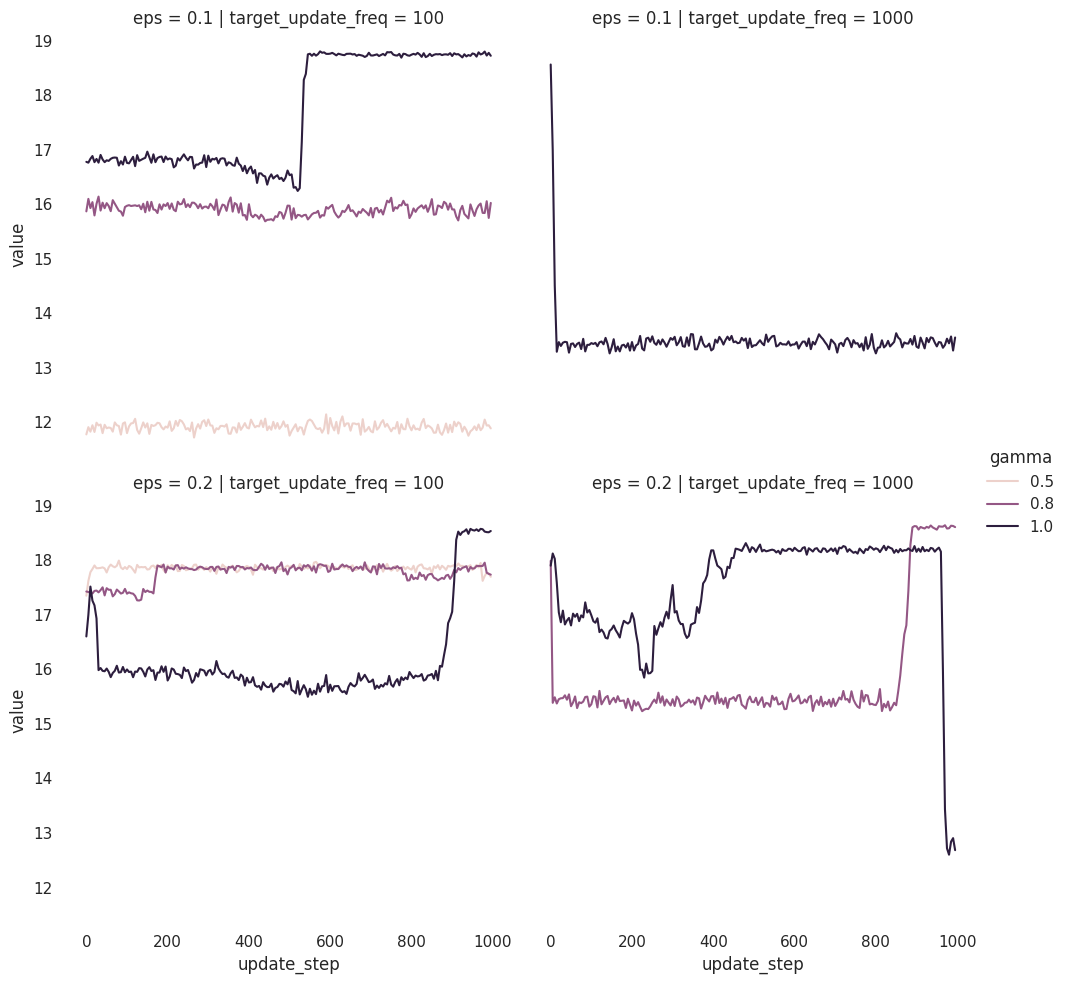

In [29]:
selection = {'eps': 0.2, 'gamma': 0.8, 'lr': '3.e-4', 'metric': 'contributions', 'sampling': 'greedy', 'target_update_freq': 1000}

focus = ['update_step', 'gamma', 'target_update_freq', 'eps']

# selection = {k: v for k, v in ref.items() if k != focus}

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if k not in focus
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='line', ci=None)


# fg.set(ylabel='cross entropy')
